In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

(2160, 3840, 3)


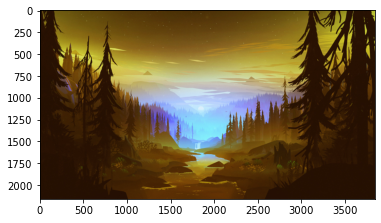

In [4]:
bg_img = cv2.imread('bg_image.jpg')

print(bg_img.shape)

plt.imshow(bg_img)
plt.show()

In [5]:
overlay_imgs=glob.glob("images2/*.jpg")

In [6]:
import random

random_index = random.randint(0,len(overlay_imgs)-1)

print(overlay_imgs[random_index])

images2/seasonal-c58c7775-92ed-4b17-9b81-a9c27b6e7ae3.jpg


In [9]:
front_img = cv2.imread(overlay_imgs[random_index], cv2.IMREAD_UNCHANGED)

x_offset = random.randint(0, bg_img.shape[0]-front_img.shape[0])
y_offset = random.randint(0, bg_img.shape[1]-front_img.shape[1])

x_end = x_offset + front_img.shape[0]

y_end = y_offset + front_img.shape[1]

bg_img[x_offset:x_end, y_offset:y_end] = front_img

filename = 'synthetic_test.jpg'
cv2.imwrite(filename, bg_img)

# cv2.imshow("test", bg_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(bg_img)
plt.show()

True

In [20]:
od_img_template = {
    "source-ref": "s3://bucket/images/IMG_1186.png", 
    "bounding-box": {
        "image_size": [
            {"width": 640, "height": 480, "depth": 3}
        ], 
        "annotations": [{ "class_id": 1,
                     "top": 251,
                     "left": 399,
                     "width": 155,
                     "height": 101}]
    }, 
    "bounding-box-metadata": {
        "objects": [
            { "confidence": 1}],
        "class-map": {"0": "Product"}, 
        "type": "groundtruth/object-detection", 
        "human-annotated": "yes",
        "creation-date": "2021-11-18T02:53:27", 
        "job-name": "retail synthetic data"}
}
od_img_template

{'source-ref': 's3://bucket/images/IMG_1186.png',
 'bounding-box': {'image_size': [{'width': 640, 'height': 480, 'depth': 3}],
  'annotations': [{'class_id': 1,
    'top': 251,
    'left': 399,
    'width': 155,
    'height': 101}]},
 'bounding-box-metadata': {'objects': [{'confidence': 1}],
  'class-map': {'0': 'Product'},
  'type': 'groundtruth/object-detection',
  'human-annotated': 'yes',
  'creation-date': '2021-11-18T02:53:27',
  'job-name': 'retail synthetic data'}}

In [46]:
!rm -rf detection_data
!mkdir detection_data
!mkdir detection_data/train
!mkdir detection_data/test

Iteration 1, just detect product

In [3]:
import sagemaker
import boto3
import json
import numpy as np
import pprint as pp

sagemaker_session = sagemaker.Session()

default_bucket = 'retaildemostore'
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

sess = sagemaker.Session()

base_job_prefix = 'retail_store'
s3 = boto3.client('s3')

In [47]:
synth_dir = 'detection_data'

train = False

if train:
    manifest_file = 'train_manifest.json'
    num_images = 1000
else:
    manifest_file = 'test_manifest.json'
    num_images = 300
    

f = open(manifest_file, 'w')
    
count=0
for x in range(num_images):
    bg_img = cv2.imread('bg_image.jpg')

    img_obj = od_img_template

    width = bg_img.shape[1]
    height = bg_img.shape[0]
    depth = bg_img.shape[2]

    img_obj["bounding-box"]["image_size"] = [{'width': width, 
                                              'height': height, 
                                              'depth': depth}]
    
    num_overlay = random.randint(1,3)
    print(f'{num_overlay}=========={count}')
    
    annotations = []
    objects = []
    for y in range(num_overlay):
        
        random_index = random.randint(0,len(overlay_imgs)-1)
        front_img = cv2.imread(overlay_imgs[random_index])
        
        x_offset = random.randint(0, bg_img.shape[0]-front_img.shape[0])
        y_offset = random.randint(0, bg_img.shape[1]-front_img.shape[1])

        x_end = x_offset + front_img.shape[0]
        y_end = y_offset + front_img.shape[1]

        bg_img[x_offset:x_end, y_offset:y_end] = front_img
        
        annot_obj = dict()
        annot_obj['class_id'] = 0
        annot_obj['top']= x_offset
        annot_obj['left']= y_offset
        annot_obj['width']= front_img.shape[1]
        annot_obj['height']= front_img.shape[0]

        object_obj = dict()
        object_obj['confidence'] = 1

        annotations.append(annot_obj)
        objects.append(object_obj)
    

    img_obj['bounding-box']['annotations'] = annotations
    img_obj['bounding-box-metadata']['objects'] = objects
    if train:
        filename = f'{synth_dir}/train/synthetic_data_{count}.jpg'
    else:
        filename = f'{synth_dir}/test/synthetic_data_{count}.jpg'
        
        
    cv2.imwrite(filename, bg_img)
    key_name = f'{base_job_prefix}/{filename}'
    s3.upload_file(filename, default_bucket, key_name)
    
    s3_path = f's3://{default_bucket}/{key_name}'
    
    img_obj['source-ref'] = s3_path
    f.write(json.dumps(img_obj) + "\n")
    count+=1

f.close()

s3.upload_file(manifest_file, default_bucket, manifest_file)

1==========0
1==========1
1==========2
3==========3
1==========4
1==========5
2==========6
2==========7
3==========8
3==========9
3==========10
3==========11
1==========12
3==========13
1==========14
3==========15
2==========16
1==========17
1==========18
1==========19
2==========20
1==========21
1==========22
1==========23
3==========24
1==========25
3==========26
2==========27
3==========28
3==========29
2==========30
1==========31
2==========32
1==========33
2==========34
2==========35
2==========36
1==========37
2==========38
1==========39
3==========40
2==========41
2==========42
2==========43
2==========44
1==========45
3==========46
1==========47
1==========48
2==========49
2==========50
2==========51
3==========52
1==========53
2==========54
1==========55
3==========56
3==========57
3==========58
1==========59
1==========60
3==========61
3==========62
1==========63
2==========64
2==========65
3==========66
1==========67
3==========68
3==========69
1==========70
1==========71
3=

In [23]:
bg_img.shape

(2160, 3840, 3)

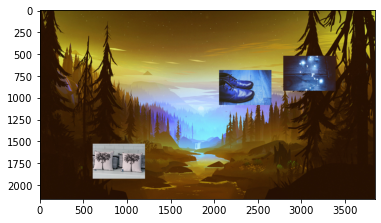

In [24]:
plt.imshow(bg_img)
plt.show()